In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# import selenium
# from selenium import webdriver

In [2]:
# def get_link_urls(url,driver):
#     driver.get(url)
#     urls = []
#     for link in d.find_elements_by_tag_name('a'):
#         urls.append(link.get_attribute('href'))
#     return urls

# d = webdriver.Safari()
# urls = get_link_urls("http://localhost:8080", d)
# sub_urls = []
# for url in urls:
#     sub_urls.extend(get_link_urls(url))

In [3]:

df2 = pd.read_csv('c19.csv')
print(df2.head())
print(df2.shape)



               X             Y                    Date  ConfirmedCovidCases  \
0 -856335.869598  7.036492e+06  2020/02/29 00:00:00+00                    1   
1 -856335.869598  7.036492e+06  2020/03/03 00:00:00+00                    1   
2 -856335.869598  7.036492e+06  2020/03/04 00:00:00+00                    4   
3 -856335.869598  7.036492e+06  2020/03/05 00:00:00+00                    7   
4 -856335.869598  7.036492e+06  2020/03/06 00:00:00+00                    5   

   TotalConfirmedCovidCases  ConfirmedCovidDeaths  TotalCovidDeaths  \
0                         1                   0.0                 0   
1                         2                   0.0                 0   
2                         6                   0.0                 0   
3                        13                   0.0                 0   
4                        18                   0.0                 0   

    StatisticsProfileDate  CovidCasesConfirmed  HospitalisedCovidCases  ...  \
0  2020/02/27 00:00

In [4]:
print(df2['Date'])

0      2020/02/29 00:00:00+00
1      2020/03/03 00:00:00+00
2      2020/03/04 00:00:00+00
3      2020/03/05 00:00:00+00
4      2020/03/06 00:00:00+00
                ...          
634    2021/11/26 00:00:00+00
635    2021/11/27 00:00:00+00
636    2021/11/28 00:00:00+00
637    2021/11/29 00:00:00+00
638    2021/11/30 00:00:00+00
Name: Date, Length: 639, dtype: object


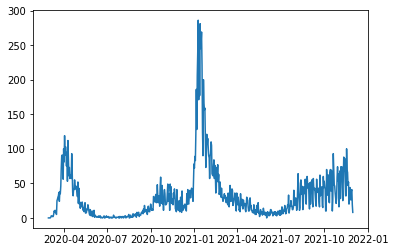

In [5]:


df2['Date'] = pd.to_datetime(df2['Date']).dt.date
df2['HCC'] = df2['HospitalisedCovidCases'].fillna(0)

# for index, row in df2.iterrows():
#     print(index, row['Date'], row['HCC'])

# d = df2['Date'][0]
prev_num = 0
df2['new_HCC'] = df2['HCC']
for index,row in df2.iterrows():
  df2.at[index, 'new_HCC'] = row['HCC'] - prev_num
  prev_num = row['HCC']
  # print(prev_num)
  # print(index, row['Date'], row['HCC'], df2.at[index, 'new_HCC'])

# print(df2['new_HCC'])
# print(df2.columns)
plt.plot(df2['Date'], df2['new_HCC'])



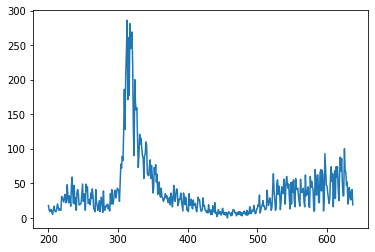

In [6]:
# i_range = []
# for i in range(293,400):
#   i_range.append(df2.Index[i, 'new_HCC'])

plt.plot(df2.iloc[200:638,42])
plt.show()

In [7]:
print("")

In [8]:
start=pd.to_datetime(df2['Date'][200])
print("Start: ", start)
end=pd.to_datetime(df2['Date'][638])
print("End: ", end)
t_full=pd.array(pd.DatetimeIndex(df2.iloc[200:638,2])).astype(np.int64)
print("Tfull: ", t_full)
dt = t_full[2] - t_full[1] 
print("Data sampling interval", dt)

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Tfull:  [1600387200000000000 1600473600000000000 1600560000000000000
 1600646400000000000 1600732800000000000 1600819200000000000
 1600905600000000000 1600992000000000000 1601078400000000000
 1601164800000000000 1601251200000000000 1601337600000000000
 1601424000000000000 1601510400000000000 1601596800000000000
 1601683200000000000 1601769600000000000 1601856000000000000
 1601942400000000000 1602028800000000000 1602115200000000000
 1602201600000000000 1602288000000000000 1602374400000000000
 1602460800000000000 1602547200000000000 1602633600000000000
 1602720000000000000 1602806400000000000 1602892800000000000
 1602979200000000000 1603065600000000000 1603152000000000000
 1603238400000000000 1603324800000000000 1603411200000000000
 1603497600000000000 1603584000000000000 1603670400000000000
 1603756800000000000 1603843200000000000 1603929600000000000
 1604016000000000000 1604102400000000000 1604188800000000000
 1604275200000000000 16

1000000000.0


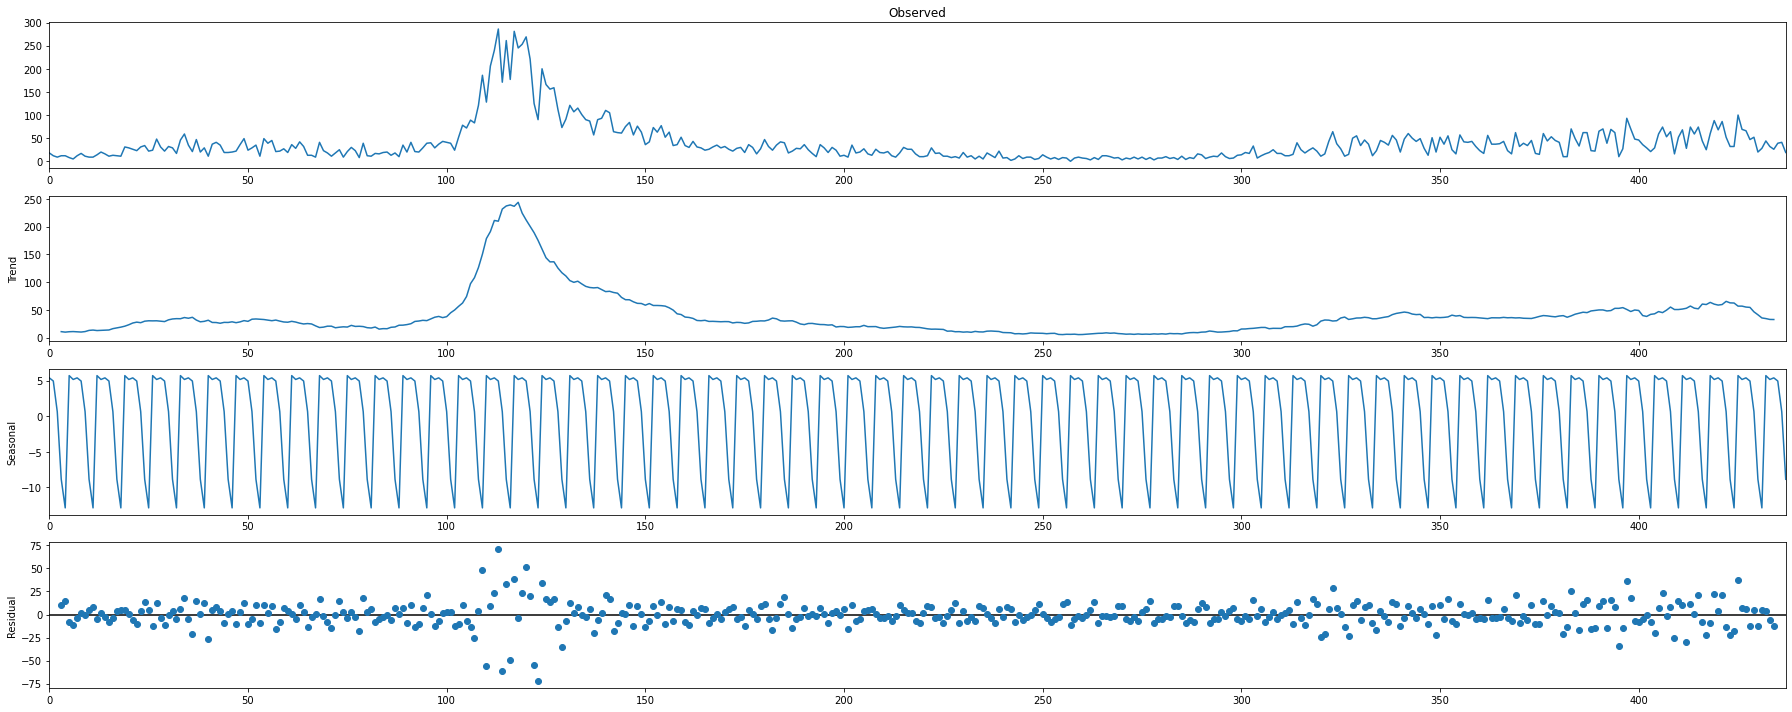

438


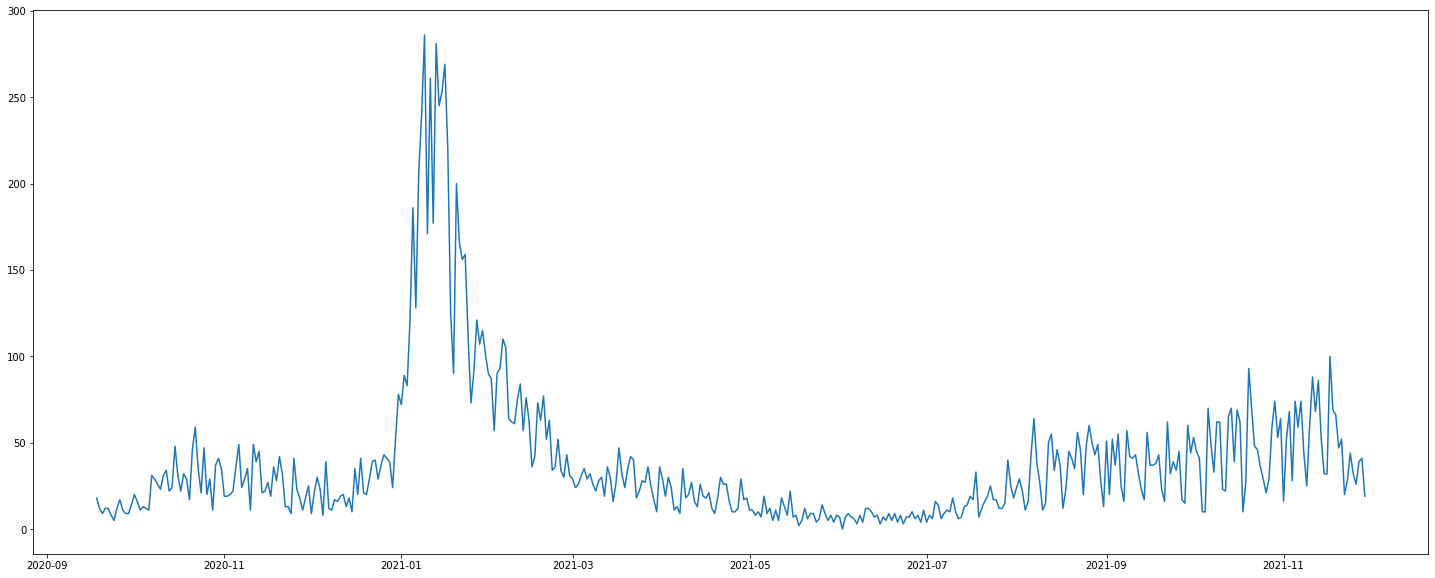

In [86]:
t = (t_full[33]-t_full[32])/60/60/24
print(t)
ss = pd.array(pd.Index(df2.iloc[200:638,42])).astype(np.int64)
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ss, model='additive', period=7)
result.plot()
pyplot.show()
trend = result.trend
seasonal = result.seasonal
# # print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
# ss = result.resid
# for i in range(ss.size):
#     if np.isnan(ss[i]):
#         ss[i] = 0
# for i in range(trend.size):
#     if np.isnan(trend[i]):
#         trend[i] = 0
# for i in range(seasonal.size):
#     if np.isnan(seasonal[i]):
#         seasonal[i] = 0
# # print(ss)
# sm.graphics.tsa.plot_acf(ss)
og_ss = ss
print(og_ss.size)
plt.plot(df2.iloc[200:638, 2], ss)
plt.show()

[ 12   9  12  12   8   5  12  17  11   9   9  14  20  16  11  13  12  11
  31  29  26  23  31  34  22  24  48  31  22  32  29  17  46  59  35  21
  47  20  29  11  37  41  35  19  19  20  22  36  49  24  29  35  11  49
  39  45  21  22  27  19  36  28  42  32  13  13   9  41  23  18  11  18
  25   9  21  30  23   8  39  12  11  17  16  19  20  13  18  10  35  20
  41  21  20  29  39  40  29  37  43  41  39  24  52  78  72  89  83 121
 186 128 206 240 286 171 261 177 281 245 253 269 221 125  90 200 166 156
 159 112  73  91 121 107 115 101  90  87  57  90  93 110 105  64  62  61
  75  84  57  76  63  36  42  73  63  77  52  63  34  36  52  34  30  43
  31  29  24  26  31  35  29  32  26  22  28  30  19  36  30  16  27  47
  32  24  35  42  40  18  22  28  27  36  25  17  10  36  29  19  30  24
  11  13   9  35  18  20  27  16  13  26  19  18  21  12   9  18  30  26
  26  16  10  10  12  29  17  18  11  11   8  10   7  19   9  12   5  11
   5  18  13   8  22   7   8   2   5  12   6   9   

C:\Users\ben\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66658.16441588975, tolerance: 102.6417
  positive)


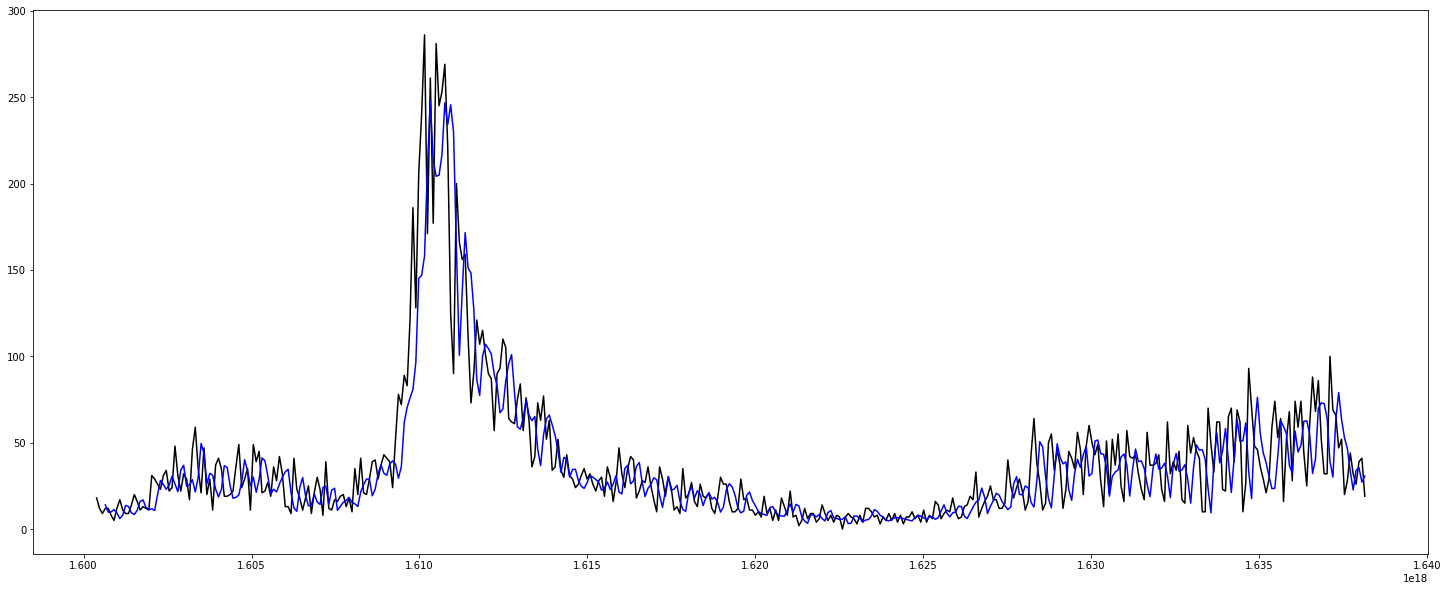

In [87]:
stride = 1
lag = 2 #determines the feature vector size
dd = 1 #number of samples in a day 
q = 1
XX = og_ss[0:og_ss.size - q - lag * dd:stride]
for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    print(X)
    XX = np.column_stack((XX,X))
  # print(XX.size) #will be size = lag * X_size
yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
# print("SS:",ss.size)
# print("yy:",yy.size)
tt = t_full[lag*dd+q::stride]
  # print(tt.size)
from sklearn.model_selection import train_test_split 
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
model = Lasso(fit_intercept=False, alpha=0).fit(XX[train], yy[train]) 
  # print(model.intercept_, model.coef_)

y_pred = model.predict(XX) 
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(yy, y_pred)
rmse = math.sqrt(mse)
print("mse:", rmse)

# print(XX.shape)
# print(og_ss.size)
# print(ss.size)
# print(y_pred.size)
# y_pred = y_pred + + seasonal[3:] + trend[3:]
# og_ss = og_ss + seasonal + trend
yy = yy + seasonal[3:] + trend[3:]
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(t_full, og_ss, color='black')
plt.plot(tt, y_pred, color='blue')
plt.show()




In [74]:
def train_predict_Ridge(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Ridge 
    model = Ridge(fit_intercept=True, alpha=5).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates = pd.to_datetime(tt_full2)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




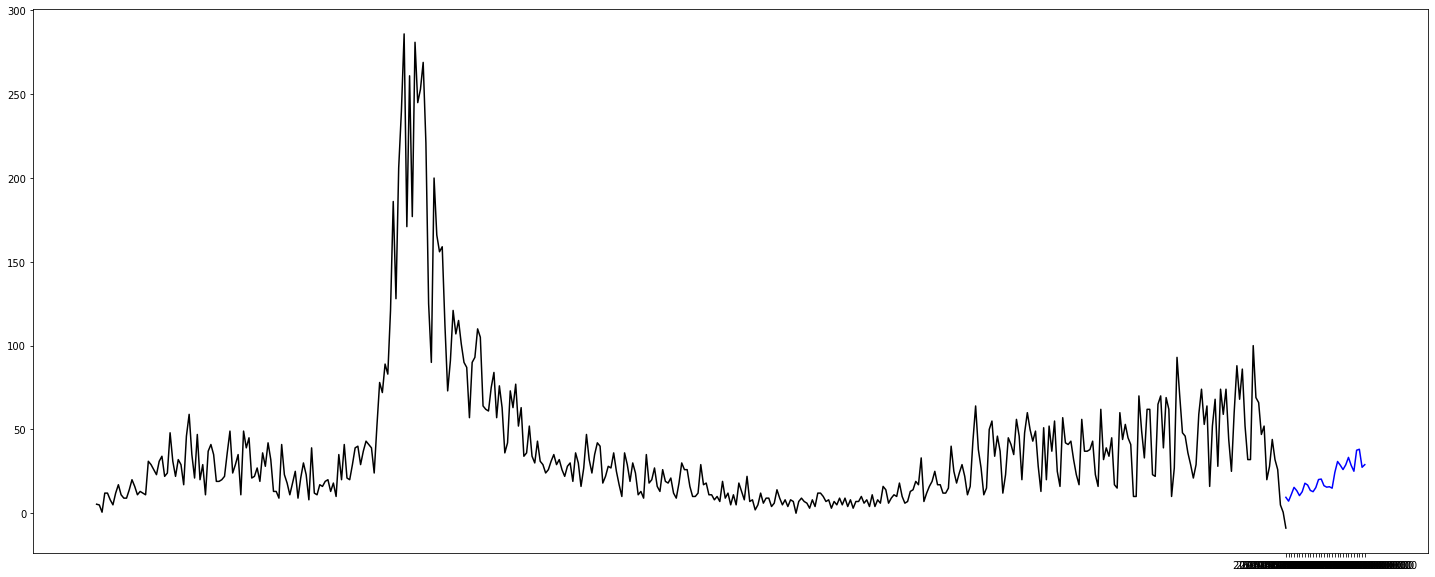

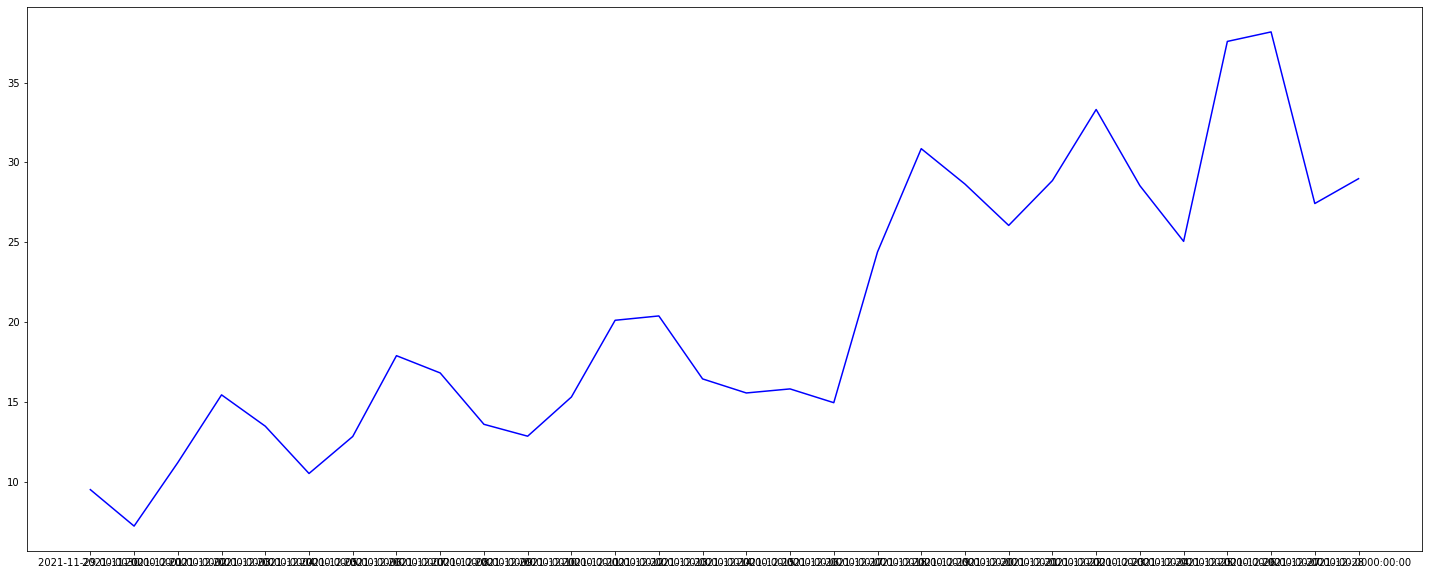

RMSE:  21.73898867970227


In [75]:
rmse_30 = train_predict_Ridge(30, 1, 2, 1)
print("RMSE: ", rmse_30)

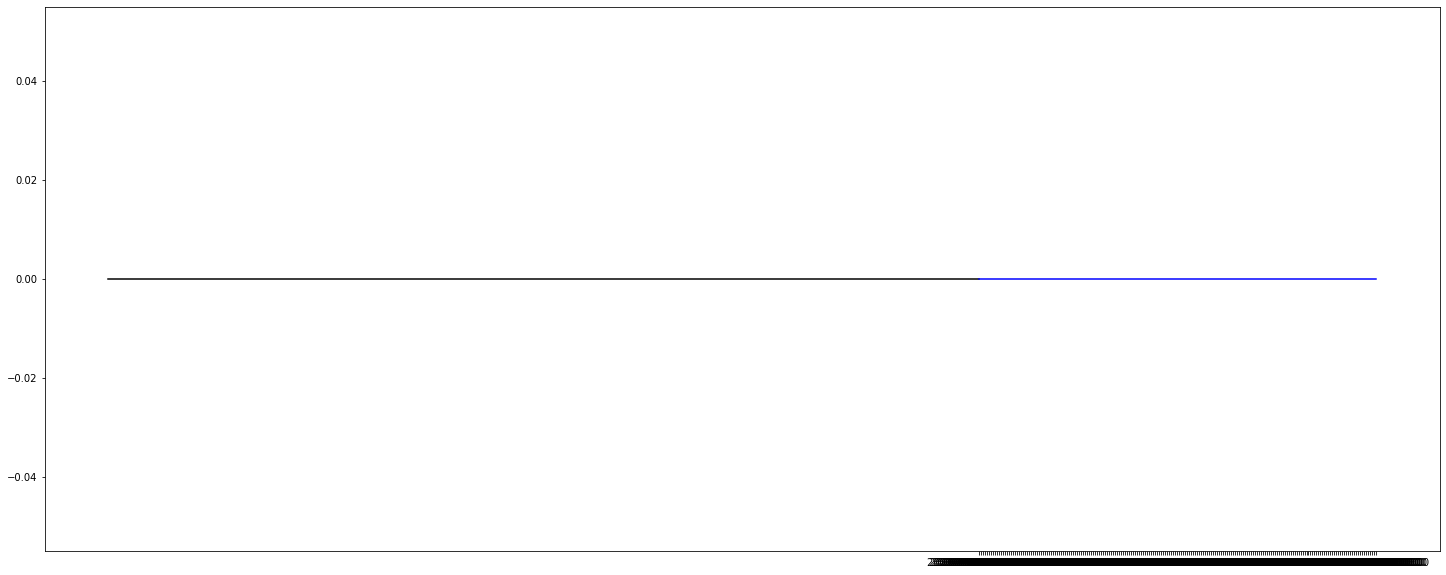

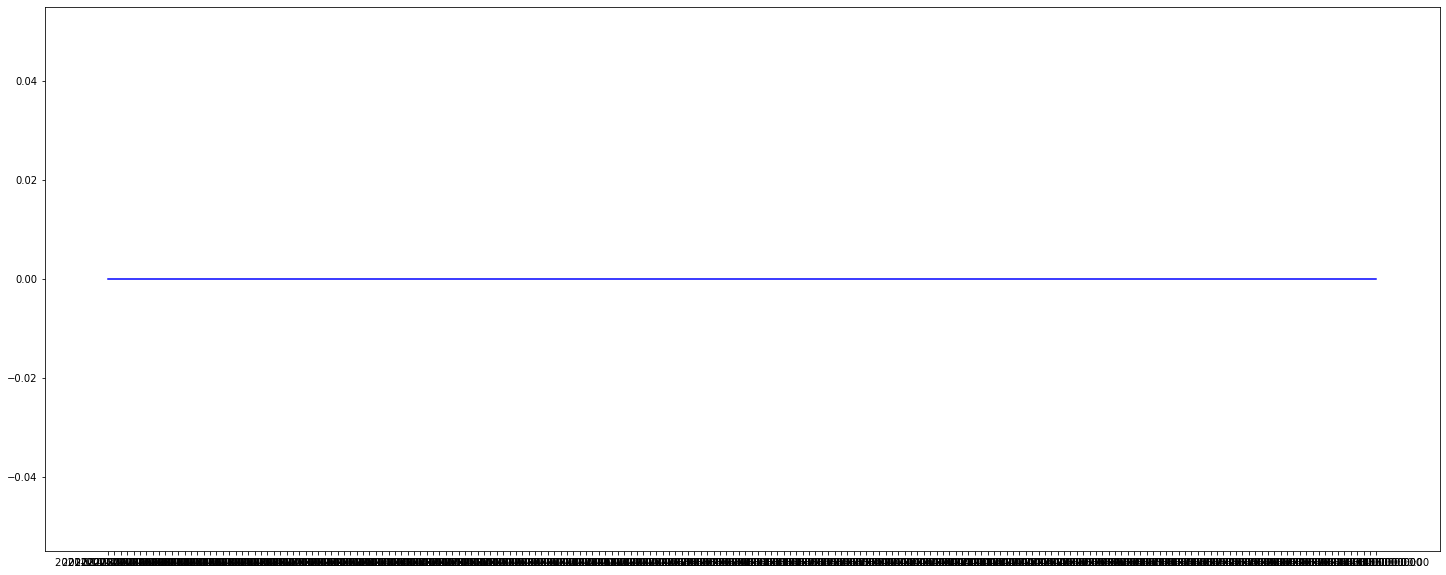

RMSE 100 days:  0.0


In [13]:
rmse_200 = train_predict_Ridge(200,1,3,1)
print("RMSE 100 days: ", rmse_200)

In [14]:
def train_predict_Lasso(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Lasso 
    model = Lasso(fit_intercept=True, alpha=10).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates = pd.to_datetime(tt_full2)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_mode

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_mode

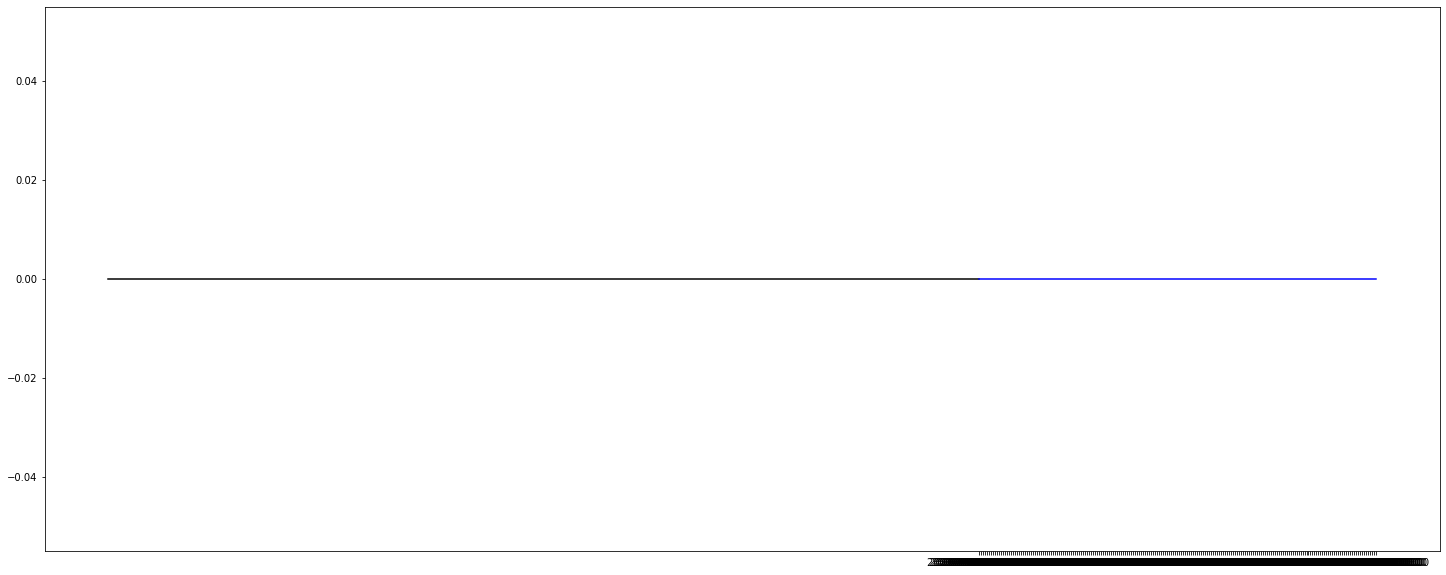

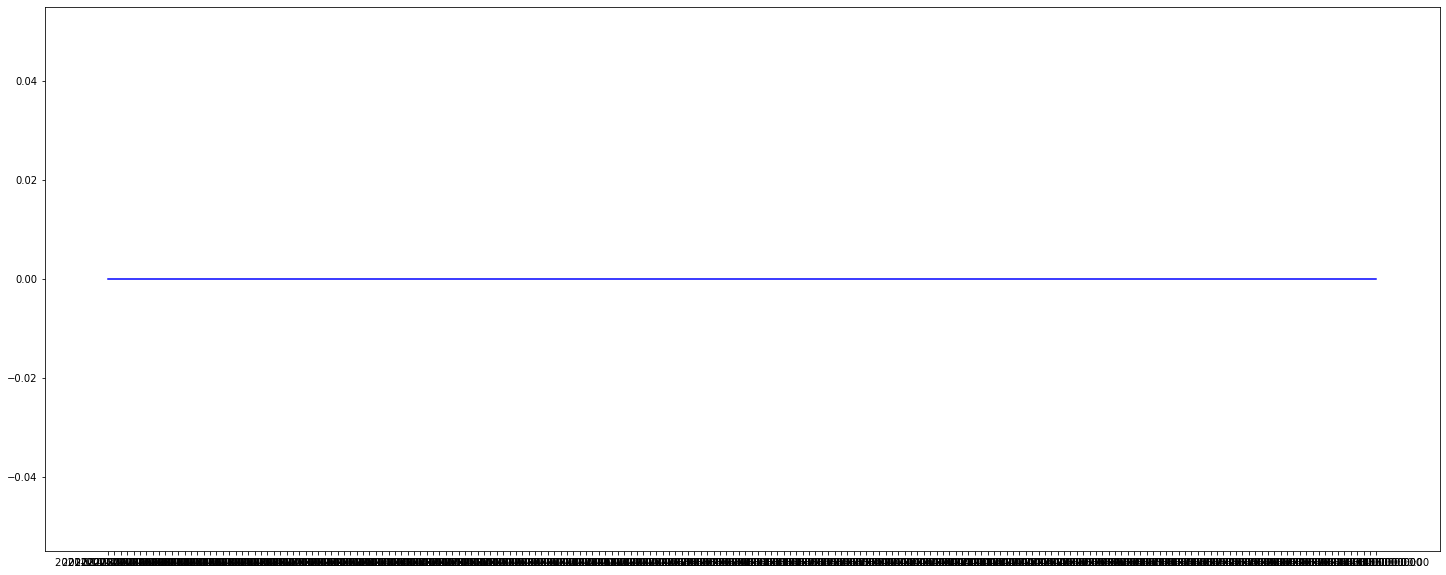

RMSE lasso 200: 0.0


In [15]:
rmse_lasso_200 = train_predict_Lasso(200, 1, 2, 1)
print("RMSE lasso 200:", rmse_lasso_200)

In [16]:
def train_predict_LR(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(fit_intercept=True, penalty='l2').fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates = pd.to_datetime(tt_full2)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




In [17]:
rmse_lr_200 = train_predict_LR(10, 1, 2, 1)
print("rmse lr 200:", rmse_lr_200)

C:\Users\ben\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

In [ ]:
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2.iloc[:,42], model='additive', period=1)
result.plot()
pyplot.show()
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)



from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2.iloc[:,42], model='additive', period=7)
result.plot()
pyplot.show()
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)



from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2.iloc[:,42], model='additive', period=30)
result.plot()
pyplot.show()
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)


In [41]:

print(y_pred.size)

438
438
870
435


In [31]:
ss

array([ 10.0157513 ,  14.89132734,  -8.40590768, -11.15014731,
        -3.94738234,   1.92698497,  -0.61634056,   4.73003702,
         8.17704163,  -4.54876483,   1.70699554,  -2.94738234,
        -7.78730075,  -3.90205485,   3.30146559,   4.89132734,
         4.59409232,   0.5641384 ,  -5.80452519,  -9.93015789,
         3.38365944,  13.15860845,   4.46275591, -11.97733625,
        12.42128126,  -4.09023948, -11.93015789,  -0.7591977 ,
         4.15860845,  -4.39438695,   6.16552089,  17.5641384 ,
        -5.37595377, -20.64444361,  14.66937373,   0.30146559,
        12.46275591, -26.1201934 ,   4.42128126,   8.33833195,
         4.06984211,  -9.18776913,   0.44432273,   4.31989877,
       -10.69162197,   2.42128126,  12.90976052, -10.35872932,
        -4.90205485,  10.15860845,  -9.2515298 ,  10.59409232,
         2.13556697,   9.05261766, -15.64444361,  -8.47348342,
         7.58717987,   4.03418448,   0.8798066 ,  -5.29300446,
        10.48118909,   2.35555639, -13.04491199,  -2.84